## An introduction to the Materials Project API

The Materials Project is an open database of computed and experimental materials information, maintained by the Lawrence Berkeley National Laboratory. It provides crystal structures, thermodynamic data, electronic properties, and more for over 200,000 inorganic compounds. By exposing this wealth of data through a programmable interface, the Materials Project API lets you:

- Query compositions and properties (e.g. band gaps, formation energies, elastic tensors) directly from Python or any HTTP client.
- Download crystal structures in formats like CIF or POSCAR for further analysis.
- Build phase diagrams, compute Pourbaix diagrams, or fetch provenance metadata for data-quality tracking.

Because most entries arise from density functional theory (DFT) calculations, it’s important to bear in mind the usual DFT caveats—absolute energies may shift by tenths of an eV, and band gaps are typically underestimated. However, for exploring trends across chemical families, screening candidate materials, or automating data-driven workflows, the API is an indispensable tool.

### Getting started: your API key

1. Create a free account at https://materialsproject.org.
2. After logging in, navigate to My Dashboard → API Key to reveal your personal key.
3. Enter it in the cell below


### Worked example: analysing Chalcogenide Band Gaps

This script uses the Materials Project API to:
1. Download materials containing S, Se, or Te
2. Filter and classify them by band gap and stability
3. Plot their band gap distributions (original and corrected)
4. Randomly select one promising direct-gap candidate. 

First things first, we will need to put together the required imports

In [1]:
from mp_api.client import MPRester                      # Access the Materials Project database
from pymatgen.core import Element                       # Get properties like atomic mass and number
from collections import defaultdict                     # Automatically create default values in dicts
import pandas as pd                                     # Handle and analyze tabular data
import matplotlib.pyplot as plt                         # Create plots and figures
import seaborn as sns                                   # Make attractive statistical plots (e.g. violin plots)
import random                                           # Random selection from lists or ranges
from pymatgen.core.composition import Composition       # Parse and work with chemical formulas
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter  # Build and visualize phase diagrams


Now we're going to set some varaibles that will apply through the notebook

In [ ]:
API_KEY = "YOUR_API_KEY"                                 # <-- Replace with your Materials Project API key

chalcogens = {"S", "Se", "Te"}                           # Elements of interest: chalcogens (excluding oxygen)

gap_by_chalcogen = defaultdict(list)                     # Store band gaps grouped by chalcogen element
candidates = []                                          # Store promising candidate materials


Then we peform a download from the materials project

In [3]:
with MPRester(API_KEY) as mpr:                              # Connect to Materials Project using your API key
    all_entries = []                                        # Store all retrieved material entries

    for chalcogen in chalcogens:                            # Loop over each chalcogen (S, Se, Te)
        entries = mpr.materials.summary.search(
            band_gap=(0.01, None),                          # Filter: must be insulating or semiconducting
            elements=[chalcogen],                           # Filter: must contain the current chalcogen
            fields=[                                        # Request only these properties from the database
                "material_id",                              # Unique Materials Project ID
                "band_gap",                                 # Band gap in eV
                "elements",                                 # Elements in the compound
                "formula_pretty",                           # Pretty-printed chemical formula
                "energy_above_hull",                        # Stability (eV/atom above convex hull)
                "is_gap_direct"                             # Whether the band gap is direct
            ]
        )
        all_entries.extend(entries)                         # Add the new entries to the full results list


/Users/alex/anaconda3/envs/work/lib/python3.10/site-packages/mp_api/client/mprester.py:230: UserWarning: mpcontribs-client not installed. Install the package to query MPContribs data, or construct pourbaix diagrams: 'pip install mpcontribs-client'
  warnings.warn(


Retrieving SummaryDoc documents:   0%|          | 0/2820 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/4095 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/10690 [00:00<?, ?it/s]

Then we filter and organise the materials based on some conditions


In [4]:
records = []                                              # Store (chalcogen, raw gap, corrected gap) tuples

for e in all_entries:
    if e.band_gap is None:                                # Skip entries with missing band gap data
        continue

    syms = {el.symbol for el in e.elements}               # Get the set of element symbols in the compound

    if not (2 <= len(syms) <= 3):                         # Only keep binaries or ternaries
        continue

    found = syms & chalcogens                             # Find which chalcogens are present
    if len(found) != 1:                                   # Must contain exactly one chalcogen
        continue

    ch = found.pop()                                      # Get the chalcogen symbol
    raw_gap = e.band_gap                                  # Raw (uncorrected) band gap

    corr_gap = 1.34 * raw_gap + 0.913                     # Apply empirical correction to the band gap 
                                                          # [https://doi.org/10.1021/co200012w]

    gap_by_chalcogen[ch].append(raw_gap)                 # Add to per-chalcogen band gap list
    records.append((ch, raw_gap, corr_gap))              # Save for later plotting

    stable = (e.energy_above_hull is not None and
              e.energy_above_hull < 0.01)                # Check if material is stable (near hull)

    direct = bool(e.is_gap_direct)                        # Check if band gap is direct

    if stable and direct and 1.1 <= corr_gap <= 1.5:      # Filter for promising candidates
        candidates.append((
            e.material_id,                                # Materials Project ID
            e.formula_pretty,                             # Pretty formula
            corr_gap,                                     # Corrected band gap
            e.energy_above_hull                           # Stability in eV/atom
        ))

In [5]:
df = pd.DataFrame(                                       # Create a DataFrame from the collected records
    records,
    columns=["Chalcogen", "Band Gap (eV)", "Corrected Gap (eV)"]
)

order = sorted(                                          # Sort chalcogen labels by increasing atomic mass
    chalcogens,
    key=lambda x: Element(x).atomic_mass
)

df.to_csv("band_gaps.csv", index=False)                  # Save the DataFrame as a CSV file (no row index)

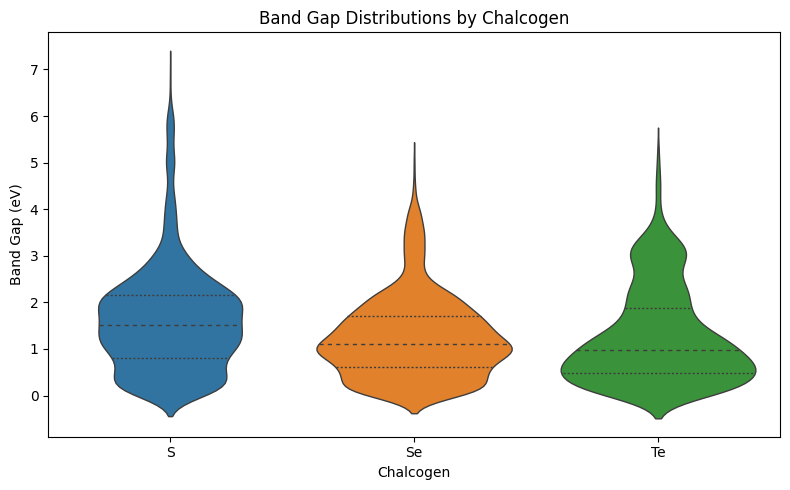

In [6]:
plt.figure(figsize=(8, 5))                               # Set the figure size to 8x5 inches

sns.violinplot(                                          # Draw a violin plot to show the distribution of values
    data=df,                                             # Use the DataFrame created earlier
    x="Chalcogen",                                       # X-axis: chalcogen element (S, Se, Te)
    y="Band Gap (eV)",                                   # Y-axis: raw band gap values
    order=order,                                         # Ensure elements are ordered by atomic mass
    inner="quartile",                                    # Show quartile lines inside each violin
    linewidth=1                                          # Set the outline thickness of the violins
)

plt.title("Band Gap Distributions by Chalcogen")         # Set the plot title
plt.xlabel("Chalcogen")                                  # Label the X-axis
plt.ylabel("Band Gap (eV)")                              # Label the Y-axis
plt.tight_layout()                                       # Adjust layout to avoid overlapping labels/margins
plt.savefig("band_gap_violin.png", dpi=300)              # Save the figure as a PNG with 300 dpi resolution
plt.show()                                               # Display the plot (e.g., in Jupyter or scripts)


In [7]:
if candidates:                                           # Check if any good candidate materials were found
    mid, formula, cg, hull = random.choice(candidates)  # Randomly select one candidate from the list

    print("Random binary chalcogenide candidate:")       # Print a header
    print(f"  MP-ID: {mid}")                             # Print Materials Project ID
    print(f"  Formula: {formula}")                       # Print chemical formula
    print(f"  Corrected Gap: {cg:.2f} eV")               # Print corrected band gap (2 decimal places)
    print(f"  Energy above hull: {hull:.4f} eV")         # Print energy above hull (4 decimal places)

else:
    print("No binary candidates found.")                 # Inform the user if no candidates matched the criteria


Random binary chalcogenide candidate:
  MP-ID: mp-1209952
  Formula: Pr3CrS6
  Corrected Gap: 1.24 eV
  Energy above hull: 0.0066 eV


In [8]:
chemsys = Composition(formula).elements                 # Get a list of Element objects from the formula
parts = [str(el) for el in chemsys]                     # Convert elements to strings (e.g. ["Cu", "Fe", "S"])
single = "-".join(parts) + "-"                          # Construct a chemical system string like "Cu-Fe-S-"
print(f"Chemical system: {single[:-1]}")                # Print the chemical system (remove trailing dash)

# 2. Connect and fetch only experimentally observed entries for the system
with MPRester(API_KEY) as mpr:                          # Connect to Materials Project with API key
    # Search for entries in the chemical system
    # 'theoretical = True' means it’s a predicted structure, not observed experimentally
    docs = mpr.materials.summary.search(
        chemsys=[single[:-1]] + [s for s in parts],     # Search full system and individual elements
        fields=["material_id", "theoretical"]           # Only retrieve ID and theoretical flag
    )

ids = [d.material_id for d in docs]                     # Extract the material IDs from the results

# 3. Download full entry data for those IDs
with MPRester(API_KEY) as mpr:                          # Reconnect to fetch full entry data
    exp_entries = mpr.get_entries(ids)                  # Get full entries for phase diagram construction

# 4. Build and show the phase diagram
pd_exp = PhaseDiagram(exp_entries)                      # Create a phase diagram from the entries
plotter = PDPlotter(pd_exp)                             # Initialize the plotting tool
plotter.show()                                          # Display the phase diagram

Chemical system: Pr-Cr-S


/Users/alex/anaconda3/envs/work/lib/python3.10/site-packages/mp_api/client/mprester.py:230: UserWarning: mpcontribs-client not installed. Install the package to query MPContribs data, or construct pourbaix diagrams: 'pip install mpcontribs-client'
  warnings.warn(


Retrieving SummaryDoc documents:   0%|          | 0/52 [00:00<?, ?it/s]

Retrieving ThermoDoc documents:   0%|          | 0/133 [00:00<?, ?it/s]